In [10]:
import ms_entropy as me
import pandas as pd

from matchms.importing import load_from_msp
from utils import generate_compound_name_options

from matchms import Spectrum
from matchms.filtering import select_by_mz

In [3]:
query = list(load_from_msp("../data/filtered/simulated_matchms_filter_1%I_all_peaks.msp"))
reference = list(load_from_msp("../data/experimental/RECETOX_GC-EI_MS_20201028.msp"))

In [3]:
peaks_query = {}
for x in query:
    peaks_query[x.get("compound_name")] = x.peaks.to_numpy

In [4]:
peaks_references = {}
for x in reference:
    peaks_references[x.get("compound_name")] = x.peaks.to_numpy

In [5]:
results = {
    "query": list(),
    "reference": list(),
    "scores": list()
}

for query_key, query_value in peaks_query.items():
    ref_options = generate_compound_name_options(query_key)
    for opt in ref_options:
        ref_value = peaks_references.get(opt)

        if ref_value is not None:
            entropy = me.calculate_entropy_similarity(query_value, ref_value, ms2_tolerance_in_da=0.0035)
            results["query"].append(query_key)
            results["reference"].append(opt)
            results["scores"].append(entropy)

In [6]:
results_df = pd.DataFrame(results)
results_df.to_csv("../data/output_matching/entropy/entropy_tol_0.0035da.tsv", sep="\t", index=False)

In [9]:
query_entropy = [me.calculate_spectral_entropy(x) for x in peaks_query.values()]
reference_entropy = [me.calculate_spectral_entropy(x) for x in peaks_references.values()]

(array([  6.,  10.,  39.,  39.,  66., 106.,  54.,  34.,  24.,   6.]),
 array([0.67526078, 1.10719573, 1.53913069, 1.97106564, 2.40300059,
        2.83493567, 3.2668705 , 3.69880533, 4.13074017, 4.56267548,
        4.99461031]),
 <BarContainer object of 10 artists>)

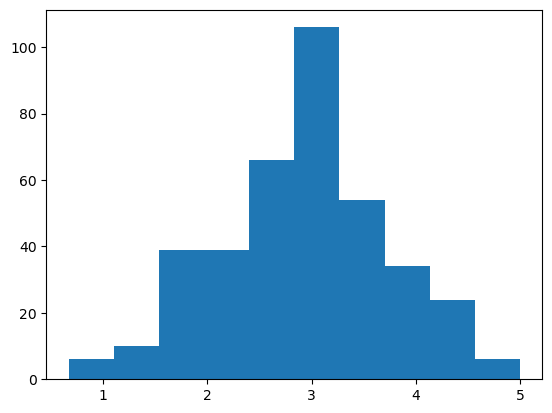

In [11]:
from matplotlib import pyplot as plt

plt.hist(reference_entropy)

In [14]:
spectrum_name = "Acephate"
exp_mz_upper_limit = 200
da_tol = 0.0035

def entropy_similarity_comparison(spectrum_name, exp_mz_upper_limit, da_tol):
    exp = get_spectrum_by_name(reference, spectrum_name)
    sim = get_spectrum_by_name(query, spectrum_name)

    exp_filtered = select_by_mz(exp, 0, exp_mz_upper_limit)

    unfiltered_entropy = entropy_similarity(sim, exp, da_tol)
    unfiltered_unweighted_entropy = entropy_similarity(sim, exp, da_tol, weighted=False)
    filtered_entropy = entropy_similarity(sim, exp_filtered, da_tol)
    filtered_unweighted_entropy = entropy_similarity(sim, exp_filtered, da_tol, weighted=False)

    scores = [unfiltered_entropy, unfiltered_unweighted_entropy, filtered_entropy, filtered_unweighted_entropy]

    tuples = [
        (spectrum_name, "unfiltered", "weighted"),
        (spectrum_name, "unfiltered", "unweighted"),
        (spectrum_name, "filtered", "weighted"),
        (spectrum_name, "filtered", "unweighted"),        
    ]

    index = pd.MultiIndex.from_tuples(tuples, names=["compound", "filtering", "weighting"])
    return pd.Series(scores, index=index)

entropy_similarity_comparison(spectrum_name, exp_mz_upper_limit, da_tol)

compound  filtering   weighting 
Acephate  unfiltered  weighted      0.092818
                      unweighted    0.089549
          filtered    weighted      0.124301
                      unweighted    0.119223
dtype: float64

In [16]:
entropy_similarity_comparison("Coronene", 310, 0.0035)

compound  filtering   weighting 
Coronene  unfiltered  weighted      0.366884
                      unweighted    0.386688
          filtered    weighted      0.366435
                      unweighted    0.394992
dtype: float64

In [15]:
from typing import List

def get_spectrum_by_name(db: List[Spectrum], name: str) -> Spectrum:
    return next((item for _, item in enumerate(db) if item.get("compound_name") == name), None)

def entropy_similarity(query: Spectrum, reference: Spectrum, da_tol: float, weighted: bool = True) -> float:
    func = me.calculate_entropy_similarity if weighted else me.calculate_unweighted_entropy_similarity
    return func(query.peaks.to_numpy, reference.peaks.to_numpy, ms2_tolerance_in_da=da_tol)

def remove_peaks_above_precursor(spectrum: Spectrum) -> Spectrum:
    cutoff = float(spectrum.get("precursor_mz")) + 20
    return select_by_mz(spectrum, 0, cutoff)